In [1]:
# lib
import os
import gc
import random
import math
import time

import albumentations as A
import copy
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from albumentations.pytorch.transforms import ToTensorV2
from glob import glob
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch_optimizer
import timm
from torch.utils.data import DataLoader, Dataset
from torch.optim.optimizer import Optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')

#import warnings
#warnings.filterwarnings("ignore")

from fastprogress import master_bar, progress_bar

if not os.path.exists('models'):
    os.mkdir('models')


def seed_everything(seed=777):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    #torch.backends.cudnn.deterministic = True

SEED = 777
seed_everything(SEED)

torch.__version__

'1.7.0'

In [2]:
data_path = '../input/cassava-leaf-disease-classification/'
#data_path = '../input/debug/'
#data_path = '../input/train_images256/'

In [3]:
def get_logger(filename='log', save=True):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    
    if save:
        handler2 = FileHandler(filename=f"{filename}.log")
        handler2.setFormatter(Formatter("%(message)s"))  
        logger.addHandler(handler2)
    return logger

logger = get_logger()
logger.info(f'Set seed: {SEED}')

Set seed: 777


# CFG

In [4]:
class CFG:
    device = device
    debug = False
    
    # data set 
    size = 512
    cat_nums = None
    bs = 16
    pre_load = True
    worker = 0    

    # model
    epochs = 15
    model_name = 'tf_efficientnet_b4_ns'
    hidden_size = 256
    dropout = 0.5
    
    # gradient
    iters_to_accumulate = 1
    max_grad_norm = 0.5
    criterion = nn.CrossEntropyLoss()
    metric = None
    smooth = 0.05
    
    # optimizer
    lr = 1e-4
    wd = 1e-6
    patience = 4
    optimizer = torch.optim.Adam
    optim_param = {'lr': lr, 'weight_decay': wd}
    scheduler = torch.optim.lr_scheduler.LambdaLR
    scheduler_param = {'lr_lambda': lambda epoch: 1}
    
    # snapmix
    snapmix_pct = 0.5
    snapmix_alpha = 5.0
    
if CFG.debug: data_path = '../input/debug/'

# load

{'0': 'Cassava Bacterial Blight (CBB)', '1': 'Cassava Brown Streak Disease (CBSD)', '2': 'Cassava Green Mottle (CGM)', '3': 'Cassava Mosaic Disease (CMD)', '4': 'Healthy'}


,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3
...,...,...
21392,999068805.jpg,3
21393,999329392.jpg,3
21394,999474432.jpg,1
21395,999616605.jpg,4


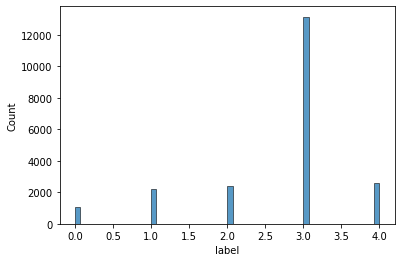

In [5]:
train_df = pd.read_csv(data_path + 'train.csv')
CFG.cat_nums = train_df.label.nunique()
with open(data_path + 'label_num_to_disease_map.json') as f:
    label2name = json.load(f)
print(label2name)
sns.histplot(train_df.label)
train_df

In [6]:
if 0:
    folds = StratifiedKFold(5)
    for n, (fold_idx) in enumerate(folds.split(train_df, train_df['label'])):
        trn_idx, val_idx = fold_idx
        print(trn_idx, val_idx)
        break

# augmentation

In [7]:
aug = A.Compose([

    A.Transpose(),
    A.HorizontalFlip(),

    A.IAAAffine(scale=1.5, rotate=10, shear=10.0, p=0.5),
    
    # Distortion
    A.OneOf([
        A.GridDistortion(),
        A.OpticalDistortion(),
        A.GridDistortion(),
    ]),
    
    # color
    A.Compose([
        A.RGBShift(),
        A.MultiplicativeNoise(per_channel=True),
        A.HueSaturationValue(hue_shift_limit=5, 
                             sat_shift_limit=5, 
                             val_shift_limit=5),       
    ]),
    
    # brightness
    A.OneOf([
        A.RandomGamma(),
        A.RandomBrightness(),
    ]),
    A.OneOf([
        A.CLAHE(clip_limit=1.0),
        A.RandomContrast(),
    ]),

    
    # Compression
    A.OneOf([
        A.JpegCompression(quality_lower=85, quality_upper=95),
        A.FancyPCA(alpha=0.9),
        A.Posterize(),
    ], p=0.2),
    
    # noise
    A.OneOf([
        A.GaussNoise(),
        A.ISONoise(),
    ], p=0.5),
    
    # blur
    A.OneOf([
        A.Blur(blur_limit=5, p=0.2),
        A.GaussianBlur(p=0.2),
        A.MedianBlur(blur_limit=5, p=0.2),
        A.MotionBlur(p=0.4),
        ], p=0.2),
    
    # Dropout
    A.OneOf([
        A.GridDropout(ratio=0.4,
                        unit_size_min=CFG.size//7,
                        unit_size_max=CFG.size//2,
                        fill_value=0,
                        random_offset=True),
        A.CoarseDropout(max_holes=50),
    ]),
    
])

In [7]:
def get_transforms(aug=None, size=CFG.size):
    resize = A.OneOf([
        A.Resize(size, size, p=0.1),
        A.RandomCrop(size, size, p=0.9),
    ], p=1.0) if aug else A.Resize(size, size)

    return A.Compose(
        [
            resize, 
            aug,
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2()
        ],
        p=1.0,
    )


class TrainDataset(Dataset):
    def __init__(self,
                 df,
                 features_col,
                 labels_col,
                 data_path,
                 transform=None,
                 pre_load=False):
        self.image_path = data_path + 'train_images/'
        self.image_id = df[features_col].values
        self.labels = torch.LongTensor(df[labels_col].values).to(device)
        self.transform = get_transforms(transform)
        self.pre_load = pre_load
        
        if self.pre_load:
            self.image_datas = np.array([
                cv2.imread(self.image_path + name)[..., ::-1]
                for name in self.image_id
            ])

    def __len__(self):
        return len(self.image_id)

    def __getitem__(self, idx):
        # read image
        if self.pre_load:
            x = self.image_datas[idx]
        else:
            x = cv2.imread(self.image_path + self.image_id[idx])[..., ::-1]

        x = self.transform(image=x)['image']  # .to(device)
        y = self.labels[idx]
        return x, y


class TestDataset(Dataset):
    def __init__(self,
                 data_path,
                 transform=None):
        self.image_paths = glob(data_path + 'test_images/*')
        self.transform = get_transforms(transform)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        x = cv2.imread(self.image_paths[idx])[..., ::-1]
        x = self.transform(image=x)['image']  # .to(device)
        return x

    
# debug
if 0:
    trn_ds = TrainDataset(train_df,
                          'image_id',
                          'label',
                          data_path,
                          transform=None,
                          pre_load=False)
    trn_dl = DataLoader(trn_ds, 
                        batch_size=32,
                        shuffle=True,
                        drop_last=True)
    for x, y in trn_dl: break
    print(x.shape, y.shape)

    test_ds = TestDataset(data_path,
                          transform=None)
    test_dl = DataLoader(test_ds, batch_size=32)
    for x_ in test_dl: break
    print(x_.shape)

# model

In [9]:
def compute_metric(preds, ys):
    if isinstance(preds, torch.Tensor):
        preds = preds.detach().cpu().numpy()
    if isinstance(ys, torch.Tensor):
        ys = ys.detach().cpu().numpy()
    preds = np.argmax(preds, axis=1)
    return (preds == ys).mean()

CFG.metric = compute_metric

In [10]:
class FocalCosineLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, xent=.1):
        super(FocalCosineLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

        self.xent = xent

        self.y = torch.Tensor([1]).cuda()

    def forward(self, input, target, reduction="mean"):
        cosine_loss = F.cosine_embedding_loss(input,
                                              F.one_hot(
                                                  target, input.size(-1)),
                                              self.y,
                                              reduction=reduction)

        cent_loss = F.cross_entropy(F.normalize(input), target, reduce=False)
        pt = torch.exp(-cent_loss)
        focal_loss = self.alpha * (1 - pt)**self.gamma * cent_loss

        if reduction == "mean":
            focal_loss = torch.mean(focal_loss)

        return cosine_loss + self.xent * focal_loss


class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, smoothing=0.0, dim=-1, reduction='mean'):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = dim
        self.reduction = reduction

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=self.dim)
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        if self.reduction == 'mean':
            return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))
        else:
            return torch.sum(-true_dist * pred, dim=self.dim)


class TaylorSoftmax(nn.Module):
    '''
    This is the autograd version
    '''
    def __init__(self, dim=1, n=2):
        super(TaylorSoftmax, self).__init__()
        assert n % 2 == 0
        self.dim = dim
        self.n = n

    def forward(self, x):
        '''
        usage similar to nn.Softmax:
            >>> mod = TaylorSoftmax(dim=1, n=4)
            >>> inten = torch.randn(1, 32, 64, 64)
            >>> out = mod(inten)
        '''
        fn = torch.ones_like(x)
        denor = 1.
        for i in range(1, self.n + 1):
            denor *= i
            fn = fn + x.pow(i) / denor
        out = fn / fn.sum(dim=self.dim, keepdims=True)
        return out


class TaylorCrossEntropyLoss(nn.Module):
    def __init__(self, n=2, ignore_index=-1, reduction='mean', smoothing=0.05):
        super(TaylorCrossEntropyLoss, self).__init__()
        assert n % 2 == 0
        self.taylor_softmax = TaylorSoftmax(dim=1, n=n)
        self.reduction = reduction
        self.ignore_index = ignore_index
        self.lab_smooth = LabelSmoothingLoss(CFG.cat_nums,
                                             smoothing=smoothing,
                                             reduction=reduction)

    def forward(self, logits, labels):
        log_probs = self.taylor_softmax(logits).log()
        #loss = F.nll_loss(log_probs, labels, reduction=self.reduction,
        #        ignore_index=self.ignore_index)
        loss = self.lab_smooth(log_probs, labels)
        return loss


CFG.criterion = TaylorCrossEntropyLoss(smoothing=CFG.smooth, reduction='none')

In [11]:
class Model(nn.Module):
    def __init__(self,
                 model_name='tf_efficientnet_b0_ns',
                 n_class=5,
                 pretrained=True,
                 freeze=False):
        super().__init__()
        backbone = timm.create_model(model_name,
                                       num_classes=5,
                                       in_chans=3,
                                       pretrained=pretrained)
        backbone = nn.Sequential(*backbone.children())
        
        self.backbone = backbone[:-2]
        self.global_pool = backbone[-2]
        
        n_features  = backbone[-1].in_features
        #self.drop = nn.Dropout2d(0.2)
        self.classifier = nn.Linear(n_features, n_class)
        
    def forward(self, x):
        feats = self.backbone(x)
        x = self.global_pool(feats).view(x.size(0), -1)
        #x = self.drop(x)
        x = self.classifier(x)
        return x, feats

# SnapMix

In [12]:
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2


def get_spm(input, target, model):
    imgsize = (CFG.size, CFG.size)
    bs = input.size(0)
    with torch.no_grad():
        output, fms = model(input)
        clsw = model.classifier
        weight = clsw.weight.data
        bias = clsw.bias.data
        weight = weight.view(weight.size(0), weight.size(1), 1, 1)
        fms = F.relu(fms)
        poolfea = F.adaptive_avg_pool2d(fms, (1, 1)).squeeze()
        clslogit = F.softmax(clsw.forward(poolfea))
        logitlist = []
        for i in range(bs):
            logitlist.append(clslogit[i, target[i]])
        clslogit = torch.stack(logitlist)

        out = F.conv2d(fms, weight, bias=bias)

        outmaps = []
        for i in range(bs):
            evimap = out[i, target[i]]
            outmaps.append(evimap)

        outmaps = torch.stack(outmaps)
        if imgsize is not None:
            outmaps = outmaps.view(outmaps.size(0), 1, outmaps.size(1),
                                   outmaps.size(2))
            outmaps = F.interpolate(outmaps,
                                    imgsize,
                                    mode='bilinear',
                                    align_corners=False)

        outmaps = outmaps.squeeze()

        for i in range(bs):
            outmaps[i] -= outmaps[i].min()
            outmaps[i] /= outmaps[i].sum()

    return outmaps, clslogit


def snapmix(input, target, alpha, model=None):

    r = np.random.rand(1)
    lam_a = torch.ones(input.size(0))
    lam_b = 1 - lam_a
    target_b = target.clone()

    if True:
        wfmaps, _ = get_spm(input, target, model)
        bs = input.size(0)
        lam = np.random.beta(alpha, alpha)
        lam1 = np.random.beta(alpha, alpha)
        rand_index = torch.randperm(bs).cuda()
        wfmaps_b = wfmaps[rand_index, :, :]
        target_b = target[rand_index]

        same_label = target == target_b
        bbx1, bby1, bbx2, bby2 = rand_bbox(input.size(), lam)
        bbx1_1, bby1_1, bbx2_1, bby2_1 = rand_bbox(input.size(), lam1)

        area = (bby2 - bby1) * (bbx2 - bbx1)
        area1 = (bby2_1 - bby1_1) * (bbx2_1 - bbx1_1)

        if area1 > 0 and area > 0:
            ncont = input[rand_index, :, bbx1_1:bbx2_1, bby1_1:bby2_1].clone()
            ncont = F.interpolate(ncont,
                                  size=(bbx2 - bbx1, bby2 - bby1),
                                  mode='bilinear',
                                  align_corners=True)
            input[:, :, bbx1:bbx2, bby1:bby2] = ncont
            lam_a = 1 - wfmaps[:, bbx1:bbx2, bby1:bby2].sum(2).sum(1) / (
                wfmaps.sum(2).sum(1) + 1e-8)
            lam_b = wfmaps_b[:, bbx1_1:bbx2_1, bby1_1:bby2_1].sum(2).sum(1) / (
                wfmaps_b.sum(2).sum(1) + 1e-8)
            tmp = lam_a.clone()
            lam_a[same_label] += lam_b[same_label]
            lam_b[same_label] += tmp[same_label]
            lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) /
                       (input.size()[-1] * input.size()[-2]))
            lam_a[torch.isnan(lam_a)] = lam
            lam_b[torch.isnan(lam_b)] = 1 - lam

    return input, target, target_b, lam_a.cuda(), lam_b.cuda()

In [13]:
class SnapMixLoss(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, criterion, outputs, ya, yb, lam_a, lam_b):
        loss_a = criterion(outputs, ya)
        loss_b = criterion(outputs, yb)
        loss = torch.mean(loss_a * lam_a + loss_b * lam_b)
        return loss

CFG.snapmix_criterion = SnapMixLoss()

# optimizer

In [14]:
# placeholder
from collections import defaultdict


class Lookahead(Optimizer):
    def __init__(self, base_optimizer, alpha=0.5, k=6):
        if not 0.0 <= alpha <= 1.0:
            raise ValueError(f'Invalid slow update rate: {alpha}')
        if not 1 <= k:
            raise ValueError(f'Invalid lookahead steps: {k}')
        defaults = dict(lookahead_alpha=alpha, lookahead_k=k, lookahead_step=0)
        self.base_optimizer = base_optimizer
        self.param_groups = self.base_optimizer.param_groups
        self.defaults = base_optimizer.defaults
        self.defaults.update(defaults)
        self.state = defaultdict(dict)
        # manually add our defaults to the param groups
        for name, default in defaults.items():
            for group in self.param_groups:
                group.setdefault(name, default)

    def update_slow(self, group):
        for fast_p in group["params"]:
            if fast_p.grad is None:
                continue
            param_state = self.state[fast_p]
            if 'slow_buffer' not in param_state:
                param_state['slow_buffer'] = torch.empty_like(fast_p.data)
                param_state['slow_buffer'].copy_(fast_p.data)
            slow = param_state['slow_buffer']
            slow.add_(group['lookahead_alpha'], fast_p.data - slow)
            fast_p.data.copy_(slow)

    def sync_lookahead(self):
        for group in self.param_groups:
            self.update_slow(group)

    def step(self, closure=None):
        # print(self.k)
        #assert id(self.param_groups) == id(self.base_optimizer.param_groups)
        loss = self.base_optimizer.step(closure)
        for group in self.param_groups:
            group['lookahead_step'] += 1
            if group['lookahead_step'] % group['lookahead_k'] == 0:
                self.update_slow(group)
        return loss

    def state_dict(self):
        fast_state_dict = self.base_optimizer.state_dict()
        slow_state = {(id(k) if isinstance(k, torch.Tensor) else k): v
                      for k, v in self.state.items()}
        fast_state = fast_state_dict['state']
        param_groups = fast_state_dict['param_groups']
        return {
            'state': fast_state,
            'slow_state': slow_state,
            'param_groups': param_groups,
        }

    def load_state_dict(self, state_dict):
        fast_state_dict = {
            'state': state_dict['state'],
            'param_groups': state_dict['param_groups'],
        }
        self.base_optimizer.load_state_dict(fast_state_dict)

        # We want to restore the slow state, but share param_groups reference
        # with base_optimizer. This is a bit redundant but least code
        slow_state_new = False
        if 'slow_state' not in state_dict:
            print(
                'Loading state_dict from optimizer without Lookahead applied.')
            state_dict['slow_state'] = defaultdict(dict)
            slow_state_new = True
        slow_state_dict = {
            'state': state_dict['slow_state'],
            'param_groups':
            state_dict['param_groups'],  # this is pointless but saves code
        }
        super(Lookahead, self).load_state_dict(slow_state_dict)
        self.param_groups = self.base_optimizer.param_groups  # make both ref same container
        if slow_state_new:
            # reapply defaults to catch missing lookahead specific ones
            for name, default in self.defaults.items():
                for group in self.param_groups:
                    group.setdefault(name, default)


class RAdam(Optimizer):
    def __init__(self,
                 params,
                 lr=1e-3,
                 betas=(0.9, 0.999),
                 eps=1e-8,
                 weight_decay=0):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        self.buffer = [[None, None, None] for ind in range(10)]
        super(RAdam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(RAdam, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError(
                        'RAdam does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(
                        p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                state['step'] += 1
                buffered = self.buffer[int(state['step'] % 10)]
                if state['step'] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2**state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 -
                                                                       beta2_t)
                    buffered[1] = N_sma

                    # more conservative since it's an approximated value
                    if N_sma >= 5:
                        step_size = math.sqrt(
                            (1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) *
                            (N_sma - 2) / N_sma * N_sma_max /
                            (N_sma_max - 2)) / (1 - beta1**state['step'])
                    else:
                        step_size = 1.0 / (1 - beta1**state['step'])
                    buffered[2] = step_size

                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * group['lr'],
                                     p_data_fp32)

                # more conservative since it's an approximated value
                if N_sma >= 5:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    p_data_fp32.addcdiv_(-step_size * group['lr'], exp_avg,
                                         denom)
                else:
                    p_data_fp32.add_(-step_size * group['lr'], exp_avg)

                p.data.copy_(p_data_fp32)

        return loss

# RAdam + LARS
class Ralamb(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        self.buffer = [[None, None, None] for ind in range(10)]
        super(Ralamb, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(Ralamb, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('Ralamb does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                # Decay the first and second moment running average coefficient
                # m_t
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                # v_t
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)

                state['step'] += 1
                buffered = self.buffer[int(state['step'] % 10)]

                if state['step'] == buffered[0]:
                    N_sma, radam_step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2 ** state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma

                    # more conservative since it's an approximated value
                    if N_sma >= 5:
                        radam_step_size = math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    else:
                        radam_step_size = 1.0 / (1 - beta1 ** state['step'])
                    buffered[2] = radam_step_size

                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)

                # more conservative since it's an approximated value
                radam_step = p_data_fp32.clone()
                if N_sma >= 5:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    radam_step.addcdiv_(-radam_step_size * group['lr'], exp_avg, denom)
                else:
                    radam_step.add_(-radam_step_size * group['lr'], exp_avg)

                radam_norm = radam_step.pow(2).sum().sqrt()
                weight_norm = p.data.pow(2).sum().sqrt().clamp(0, 10)
                if weight_norm == 0 or radam_norm == 0:
                    trust_ratio = 1
                else:
                    trust_ratio = weight_norm / radam_norm

                state['weight_norm'] = weight_norm
                state['adam_norm'] = radam_norm
                state['trust_ratio'] = trust_ratio

                if N_sma >= 5:
                    p_data_fp32.addcdiv_(-radam_step_size * group['lr'] * trust_ratio, exp_avg, denom)
                else:
                    p_data_fp32.add_(-radam_step_size * group['lr'] * trust_ratio, exp_avg)

                p.data.copy_(p_data_fp32)

        return loss    

def Ranger(params, alpha=0.5, k=6, *args, **kwargs):
    radam = RAdam(params, *args, **kwargs)
    return Lookahead(radam, alpha, k)


def RangerLars(params, alpha=0.5, k=6, *args, **kwargs):
    ralamb = Ralamb(params, *args, **kwargs)
    return Lookahead(ralamb, alpha, k)

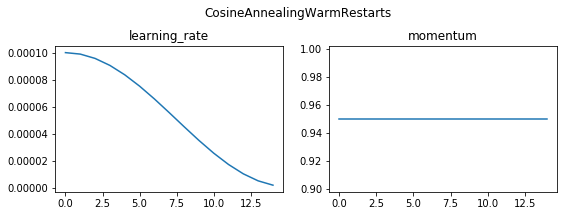

In [15]:
# show_learning_rate_scheduler
#%%capture --no-display
optim_param = {'lr': CFG.lr, 'weight_decay': CFG.wd}
CFG.optimizer = torch_optimizer.Ranger
CFG.optim_param = optim_param

scheduler_param = {
    'T_0': CFG.epochs,
    'T_mult': 1,
    'eta_min': 1e-6,
}
CFG.scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts
CFG.scheduler_param = scheduler_param


cfg = CFG
model = nn.Linear(1, 1)
optimizer = cfg.optimizer(model.parameters(), **cfg.optim_param)
scheduler = cfg.scheduler(optimizer, **cfg.scheduler_param)

def show_learning_rate_scheduler():
    lrs = []
    moms = []
    if scheduler.__class__.__name__ == 'OneCycleLR':
        step = cfg.epochs* (len(os.listdir(data_path+'train_images/')) // CFG.bs)
    else:
        step = cfg.epochs
    
    for i in range(step):
        optimizer.step()
        lrs.append(scheduler.optimizer.param_groups[0]['lr'])
        moms.append(scheduler.optimizer.param_groups[0]['betas'][0])
        scheduler.step()

    plt.figure(figsize=(9, 3))
    plt.suptitle(scheduler.__class__.__name__)
    plt.subplot(121)
    plt.title('learning_rate')
    plt.plot(lrs)
    plt.subplot(122)
    plt.title('momentum')
    plt.plot(moms)
    plt.subplots_adjust(top=0.80)
    plt.show()


show_learning_rate_scheduler()

# learn

In [16]:
class AverageMeter:
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0.
        self.avg = 0.
        self.sum = 0.
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count



class EearlyStop:
    def __init__(self, patience=4, min_delta=0.005, mode='min'):
        '''
        mode: {min, max}
        '''
        self.record = np.inf if mode == 'min' else -np.inf
        self.patience = patience
        self.min_delta = min_delta
        self.mode = mode
        self.wait = 0
        
    def cal_improve(self, val_loss: float) -> bool:
        esp = 1e-8
        ratio = (val_loss - self.record + esp) / (self.record + esp)
        if ratio > 0:
            improve = False
        else:
            improve = True if -ratio > self.min_delta else False
        return improve
    
    def stop(self, val_loss: float) -> bool:
        # improve = self.cal_improve(val_loss)
        improve = True if val_loss < self.record else False
        if self.mode == 'max': improve = not improve
        
        if improve: 
            self.wait = 0
            self.record = val_loss            
        else: self.wait += 1

        
        if self.wait > self.patience: return True
        else: return False

In [17]:
class Learner():
    def __init__(self, cfg, model):
        self.cfg = cfg

        self.criterion = cfg.criterion
        self.metric = cfg.metric
        self.scaler = torch.cuda.amp.GradScaler()

        # recorder
        self.best_loss = np.inf
        self.best_score = 0
        self.epoch = 0
        self.history = {
            'losses': [],
            'trn_losses': [],
            'trn_metrics': [],
            'val_losses': [],
            'val_metrics': [],
            'lrs': [],
        }
        self.mb = master_bar(range(1, cfg.epochs + 1))
        self.mb.write(('epoch', 'train loss', 'train metric', 'val loss',
                       'val metric', 'time'),
                      table=True)
        self.early_stop = EearlyStop(patience=CFG.patience, min_delta=0.05, mode='max')

        # model
        self.device = cfg.device
        self.model = model.to(cfg.device)
        self.optimizer = cfg.optimizer(self.model.parameters(), **cfg.optim_param)
        self.scheduler = cfg.scheduler(self.optimizer, **cfg.scheduler_param)

    def trn_fn(self, trn_loader):
        self.model.train()
        running_loss = AverageMeter()
        running_metric = AverageMeter()
        
        trn_tqdm = progress_bar(trn_loader,
                                total=int(len(trn_loader)),
                                parent=self.mb)
        for i, (xs, ys) in enumerate(trn_tqdm):
            batch_size = len(xs)
            xs = xs.to(self.device)
            ys = ys.to(self.device)

            # forward, backward
            with torch.cuda.amp.autocast():
                rand = np.random.rand()
                if rand < self.cfg.snapmix_pct:
                    xs, ya, yb, lam_a, lam_b = snapmix(xs, 
                                                       ys, 
                                                       self.cfg.snapmix_alpha, 
                                                       self.model)
                    preds, _ = self.model(xs)
                    loss = self.cfg.snapmix_criterion(self.criterion, 
                                                      preds, 
                                                      ya, 
                                                      yb, 
                                                      lam_a, 
                                                      lam_b)                                 
                else:
                    preds, _ = self.model(xs)
                    loss = self.criterion(preds, ys).mean()
                running_loss.update(loss.item(), batch_size)
            
            # backward
            loss = loss / self.cfg.iters_to_accumulate
            self.scaler.scale(loss).backward()
            
            # gradient accumulate
            if (i + 1) % self.cfg.iters_to_accumulate == 0:
                # clip grad
                self.scaler.unscale_(self.optimizer)
                torch.nn.utils.clip_grad_norm_(self.model.parameters(),
                                                self.cfg.max_grad_norm)
                # step
                self.scaler.step(self.optimizer)
                self.scaler.update()
                self.optimizer.zero_grad()
            
            # step scheduler if lr scheduler is onecycle
            if self.scheduler.__class__.__name__ == 'OneCycleLR':
                self.history['lrs'].append(self.scheduler.optimizer.param_groups[0]['lr'])
                self.scheduler.step()
                
            # metric
            metric = self.metric(preds, ys)
            running_metric.update(metric, batch_size)
            
            # set commet on child progressbar
            self.mb.child.comment = (f'loss={loss.item():.4f}, '
                                     f'metric={metric:.4f}')

        # step scheduler if lr scheduler is not onecycle
        if self.scheduler.__class__.__name__ != 'OneCycleLR':
            self.history['lrs'].append(self.scheduler.optimizer.param_groups[0]['lr'])
            self.scheduler.step()
        return running_loss.avg, running_metric.avg

    def val_fn(self, val_loader):
        self.model.eval()
        running_loss = AverageMeter()
        running_metric = AverageMeter()
        val_preds = []

        val_tqdm = progress_bar(val_loader,
                                total=int(len(val_loader)),
                                parent=self.mb)
        for i, (xs, ys) in enumerate(val_tqdm):
            batch_size = len(xs)
            xs = xs.to(self.device)
            ys = ys.to(self.device)

            self.model.eval()
            with torch.cuda.amp.autocast():
                with torch.no_grad():
                    preds, _ = self.model(xs)
                    loss = self.criterion(preds, ys).mean()
                    metric = self.metric(preds, ys)
                    
            # record
            running_loss.update(loss.item(), batch_size)
            running_metric.update(metric, batch_size)
            val_preds.append(preds.detach().cpu().numpy())

            # set commet on child progressbar
            self.mb.child.comment = (f'val_loss={loss.item():.4f}, '
                                     f'val_metric={metric:.4f}')

        val_preds = np.concatenate(val_preds)
        return running_loss.avg, running_metric.avg, val_preds

    def plot_history(self, fold_num=0):
        fig = plt.figure(figsize=(16, 3))
        fig.subplots_adjust(top=0.8)
        plt.suptitle(f'fold{fold_num}')

        # metrics
        plt.subplot(131)
        #plt.ylim(0.01, 0.03)
        plt.plot(self.history['trn_metrics'], 'C0', label='train')
        plt.plot(self.history['val_metrics'], 'C1', label='val')
        plt.title(f'Metric')
        plt.legend()
        plt.ylabel("Metric")
        plt.xlabel("Epoch")

        # loss
        plt.subplot(132)
        #plt.ylim(0.01, 0.03)
        plt.plot(self.history['trn_losses'], 'C0', label='train')
        plt.plot(self.history['val_losses'], 'C1', label='val')
        plt.title(f'Loss')
        plt.legend()
        plt.ylabel("Loss")
        plt.xlabel("Epoch")

        # lr
        plt.subplot(133)
        plt.plot(self.history['lrs'][1:], 'C0', label='lr')
        plt.title(f'Learning rate')
        plt.ylabel("lr")
        if self.history['lrs'][0] == 'OneCycleLR':
            plt.xlabel("Iteration")
        else:
            plt.xlabel("Epoch")

        plt.show()

    def fit_single(
        self,
        train_df,
        fold_idx,
        trn_loader,
        val_loader,
        fold_num=0,
    ):
        # recorder
        self.history = {
            'losses': [],
            'trn_losses': [],
            'trn_metrics': [],
            'val_losses': [],
            'val_metrics': [],
            'lrs': [],
        }
        self.history['lrs'].append(self.scheduler.__class__.__name__)
        trn_idx, val_idx = fold_idx

        # train & validate
        for epoch in self.mb:            
            self.epoch = epoch
            start_time = time.time()
            trn_loss, trn_metric = self.trn_fn(trn_loader)
            val_loss, val_metric, val_preds = self.val_fn(val_loader)

            # checkpoint
            #if val_loss < self.best_loss:
            if val_metric > self.best_score:
                logger.info(f'epoch{epoch} save best model... {val_metric}')
                #self.best_loss = val_loss
                self.best_score = val_metric
                
                oof = np.zeros((len(train_df), train_df.label.nunique()))
                oof[val_idx] = val_preds
                save_name = f"fold_{fold_num}.pth"
                self.save(save_name)
                
            # calculate time
            end_time = time.time()
            m, s = divmod(end_time - start_time, 60)

            # record
            self.history['trn_losses'].append(trn_loss)
            self.history['trn_metrics'].append(trn_metric)
            self.history['val_losses'].append(val_loss)
            self.history['val_metrics'].append(val_metric)
            self.mb.write(
                (f'{epoch}', 
                 f'{trn_loss:.6f}', 
                 f'{trn_metric:.6f}',
                 f'{val_loss:.6f}', 
                 f'{val_metric:.6f}', 
                 f'{m:.0f}:{s:.0f}'),
                table=True)
            
            # early stop
            break_flag = self.early_stop.stop(val_metric)
            if break_flag:
                logger.info(f"early stop...")
                break
                
        # record cv score
        score = self.metric(oof[val_idx], train_df.iloc[val_idx]['label'].values)
        logger.info(f"fold{fold_num} score: {score}")
        self.plot_history(fold_num)

        # del
        torch.cuda.empty_cache()

        return oof
    
    def save(self, path):
        self.model.eval()
        torch.save({
            #'model_state_dict': self.model.model.state_dict(),
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'scaler': self.scaler.state_dict(),
            'best_loss': self.best_loss,
            'epoch': self.epoch,
            'history': self.history,   
        }, path)

    def load(self, path):
        checkpoint = torch.load(path)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        self.scaler.load_state_dict(checkpoint['scaler'])
        self.best_loss = checkpoint['best_loss']
        self.epoch = checkpoint['epoch']
        self.history = checkpoint['history']

In [18]:
def run_kfold(cfg, train_df, n_fold=5, aug=None, pre_load=False):

    oof = np.zeros((len(train_df), train_df.label.nunique()))

    folds = StratifiedKFold(n_fold)
    for fold_num, (fold_idx) in enumerate(folds.split(train_df, train_df['label'])):
        logger.info(f'fold {fold_num}')
        trn_idx, val_idx = fold_idx

        trn_ds = TrainDataset(train_df.iloc[trn_idx],
                              'image_id',
                              'label',
                              data_path,
                              transform=aug,
                              pre_load=pre_load)
        val_ds = TrainDataset(train_df.iloc[val_idx],
                              'image_id',
                              'label',
                              data_path,
                              transform=None,
                              pre_load=pre_load)

        trn_dl = DataLoader(
            trn_ds,
            batch_size=CFG.bs,
            shuffle=True,
            drop_last=False,
            num_workers=cfg.worker,
        )
        val_dl = DataLoader(
            val_ds,
            batch_size=CFG.bs,
            drop_last=False,
            num_workers=cfg.worker,
        )

        model = Model(model_name=CFG.model_name)
        learner = Learner(CFG, model)
        _oof = learner.fit_single(train_df, fold_idx, trn_dl, val_dl, fold_num)
        oof += _oof
    score = compute_metric(oof, train_df.label.values)
    logger.info(f"CV score: {score}")
    del trn_ds, val_ds
    gc.collect()

    return oof, learner

fold 0


epoch,train loss,train metric,val loss,val metric,time
1,1.324416,0.647952,0.761116,0.812383,15:20
2,0.947504,0.761524,0.603190,0.856075,15:0
3,0.872018,0.786762,0.574000,0.867991,14:39
4,0.852027,0.803003,0.563704,0.872664,14:35
5,0.803591,0.812000,0.574170,0.876168,14:31
6,0.816659,0.812759,0.559265,0.876402,14:38
7,0.797719,0.818777,0.558793,0.877336,14:49
8,0.780481,0.821055,0.551032,0.877804,14:20
9,0.765409,0.829351,0.549328,0.883411,14:15
10,0.773602,0.823859,0.537183,0.883411,14:15


C:\Users\utl\anaconda3\lib\site-packages\pytorch_ranger\ranger.py:172: UserWarning: This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value) (Triggered internally at  ..\torch\csrc\utils\python_arg_parser.cpp:882.)
  exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
C:\Users\utl\anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
epoch1 save best model... 0.8123831775700935
epoch2 save best model... 0.8560747663551402
epoch3 save best model... 0.8679906542056075
epoch4 save best model... 0.8726635514018691
epoch5 save best model... 0.8761682242990654
epoch6 save best model... 0.8764018691588785
epoch7 save best model... 0.8773364485981309
epoch8 save best model... 0.877803738317757
epoch9 save best model... 

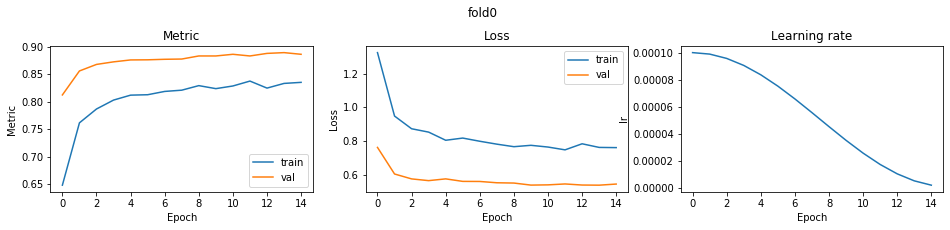

fold 1


epoch,train loss,train metric,val loss,val metric,time
1,1.330776,0.649588,0.796955,0.791589,14:18
2,0.966831,0.758252,0.614087,0.859346,14:12
3,0.868738,0.790734,0.575073,0.867523,14:16
4,0.828664,0.803061,0.555211,0.877336,14:16
5,0.815506,0.808728,0.548798,0.880607,14:16
6,0.810908,0.812642,0.544635,0.883178,14:16
7,0.794006,0.818835,0.534854,0.886916,14:16
8,0.790829,0.817842,0.533869,0.886916,14:13
9,0.773996,0.823275,0.542892,0.881308,14:16
10,0.768981,0.829994,0.541322,0.885514,14:22


C:\Users\utl\anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
epoch1 save best model... 0.791588785046729
epoch2 save best model... 0.8593457943925233
epoch3 save best model... 0.8675233644859813
epoch4 save best model... 0.8773364485981309
epoch5 save best model... 0.880607476635514
epoch6 save best model... 0.883177570093458
epoch7 save best model... 0.8869158878504673
epoch11 save best model... 0.8876168224299066
epoch14 save best model... 0.8901869158878505
fold1 score: 0.8901869158878505


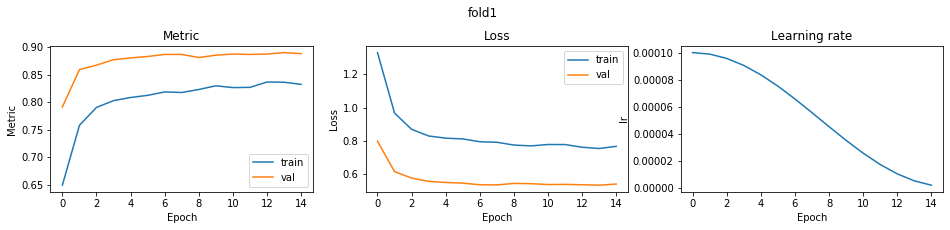

fold 2


epoch,train loss,train metric,val loss,val metric,time
1,1.348455,0.638626,0.736746,0.808834,14:35
2,0.957625,0.757273,0.582461,0.866090,14:29
3,0.865058,0.792032,0.551524,0.883384,14:33
4,0.845031,0.798691,0.528921,0.889694,14:28
5,0.825594,0.809674,0.521801,0.892265,14:28
6,0.822241,0.808097,0.523420,0.892966,14:24
7,0.790889,0.820949,0.521675,0.892031,14:30
8,0.802807,0.817619,0.519133,0.893199,14:31
9,0.799226,0.818670,0.521385,0.892732,14:28
10,0.792357,0.822000,0.513109,0.895303,14:30


C:\Users\utl\anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
epoch1 save best model... 0.8088338396821687
epoch2 save best model... 0.8660902079925216
epoch3 save best model... 0.8833839682168731
epoch4 save best model... 0.8896938537041365
epoch5 save best model... 0.8922645477915401
epoch6 save best model... 0.8929656461790138
epoch8 save best model... 0.893199345641505
epoch10 save best model... 0.8953026408039262
epoch11 save best model... 0.8955363402664174
epoch15 save best model... 0.8976396354288385
fold2 score: 0.8976396354288385


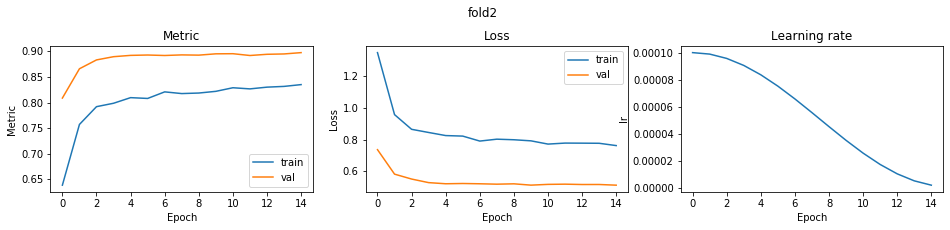

fold 3


epoch,train loss,train metric,val loss,val metric,time
1,1.360849,0.624489,0.750431,0.806029,14:33
2,0.932284,0.764050,0.604735,0.860949,14:50
3,0.874757,0.789403,0.569279,0.866791,14:60
4,0.850270,0.799509,0.568992,0.865155,15:1
5,0.835318,0.806111,0.553087,0.876607,15:11
6,0.803784,0.815808,0.540280,0.881281,14:38
7,0.792992,0.817853,0.538445,0.884786,14:37
8,0.775671,0.827141,0.535570,0.885020,14:29
9,0.776950,0.826089,0.542896,0.880112,14:48
10,0.759839,0.832457,0.540534,0.882917,15:26


C:\Users\utl\anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
epoch1 save best model... 0.8060294461322739
epoch2 save best model... 0.8609488198177144
epoch3 save best model... 0.8667913063799954
epoch5 save best model... 0.8766066838046273
epoch6 save best model... 0.881280673054452
epoch7 save best model... 0.8847861649918205
epoch8 save best model... 0.8850198644543118
epoch12 save best model... 0.8880579574666978
fold3 score: 0.8880579574666978


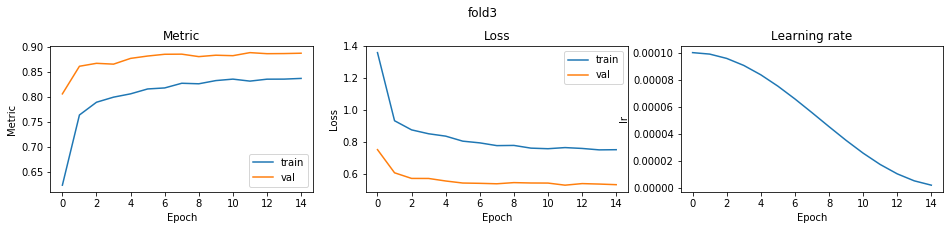

fold 4


epoch,train loss,train metric,val loss,val metric,time
1,1.348158,0.638275,0.761070,0.795747,14:47
2,0.952557,0.756163,0.591649,0.855340,15:0
3,0.875715,0.787475,0.559048,0.877775,15:7
4,0.833947,0.807337,0.556651,0.876607,14:52
5,0.839843,0.804767,0.543165,0.881514,14:42
6,0.802454,0.812945,0.539837,0.884319,14:56
7,0.793825,0.818729,0.527899,0.885721,14:52
8,0.783127,0.828017,0.539840,0.883150,14:57
9,0.761118,0.829536,0.531746,0.888993,14:47
10,0.777606,0.826206,0.538218,0.884319,14:53


C:\Users\utl\anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
epoch1 save best model... 0.7957466697826595
epoch2 save best model... 0.8553400327179248
epoch3 save best model... 0.8777751811170834
epoch5 save best model... 0.8815143725169432
epoch6 save best model... 0.884318766066838
epoch7 save best model... 0.8857209628417855
epoch9 save best model... 0.8889927553166628
early stop...
fold4 score: 0.8889927553166628


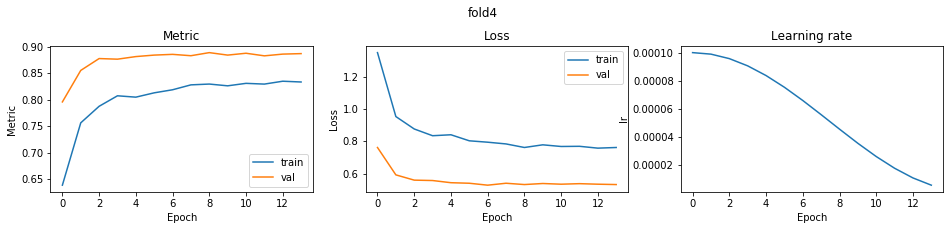

CV score: 0.8908725522269477


In [19]:
oof, learner = run_kfold(CFG, train_df, n_fold=5, aug=aug, pre_load=CFG.pre_load)

# evaluate

In [20]:
ys = train_df.label.values
print('oof score: ', compute_metric(oof, ys))

cat_columns = [f'c{i}' for i in range(CFG.cat_nums)]
oof_df = pd.DataFrame(oof, columns=cat_columns)
oof_df = pd.concat([train_df.image_id.to_frame(), oof_df], axis=1)
oof_df.to_csv('oof_df.csv')
oof_df

oof score:  0.8908725522269477


,image_id,c0,c1,c2,c3,c4
0,1000015157.jpg,1.582031,0.549805,1.015625,-1.889648,0.798340
1,1000201771.jpg,-0.879395,-0.973633,-0.247803,6.535156,-0.506348
2,100042118.jpg,-1.322266,0.972656,0.263428,-1.016602,4.488281
3,1000723321.jpg,-0.886230,4.054688,-0.693359,-0.696289,-0.546875
4,1000812911.jpg,-1.041016,-0.939941,-0.989258,7.003906,-0.617676
...,...,...,...,...,...,...
21392,999068805.jpg,-1.164062,-1.699219,-1.651367,9.578125,0.084106
21393,999329392.jpg,-1.394531,-0.838867,-1.168945,7.203125,-0.655762
21394,999474432.jpg,-0.944336,4.039062,-0.886230,-0.252197,-0.964355
21395,999616605.jpg,0.546875,0.224976,-1.337891,-1.732422,6.359375


In [21]:
oof_df.to_csv('oof_df.csv')

In [22]:
y_preds = np.argmax(oof, axis=1)
y_preds

array([0, 3, 4, ..., 1, 4, 2], dtype=int64)

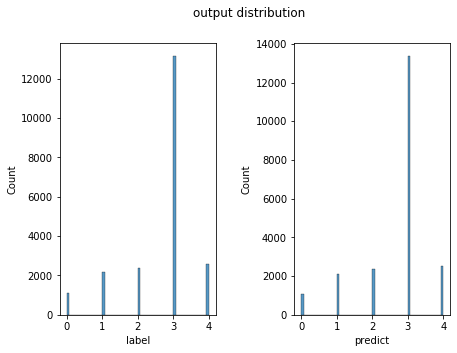

In [23]:
# compare distribution between labels and outputs
plt.figure(figsize=(7, 5))
plt.suptitle('output distribution')
plt.subplot(121)
sns.histplot(train_df.label)

plt.subplot(122)
sns.histplot(y_preds)
plt.xlabel('predict')
plt.subplots_adjust(wspace=0.5)

```python
def confusion_matrix(preds, ys):
    nunique = len(np.unique(ys))
    cm = np.zeros((nunique, nunique))
    for i, j in zip(ys, preds):
        cm[i, j] += 1
    return cm
```

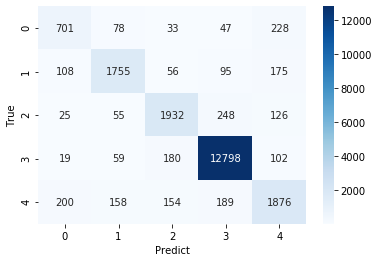

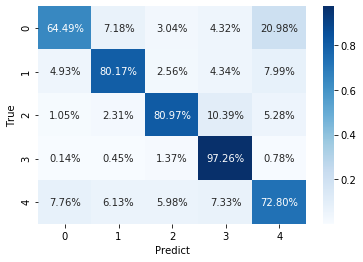

In [24]:
formats = ((None, 'd'), ('true', '.2%'))
for fmt in formats:
    cm = confusion_matrix(ys, y_preds, normalize=fmt[0])
    sns.heatmap(cm, annot=True, fmt=fmt[1], cmap='Blues')
    plt.ylabel('True')
    plt.xlabel('Predict')    
    plt.show()

In [25]:
idx = np.logical_and(ys == 0, y_preds == 4)
preds_df = pd.DataFrame(y_preds[idx],
                          columns=['predict'],
                          index=np.where(idx)[0])
ys_df = pd.DataFrame(ys[idx], 
                       columns=['label'], 
                       index=np.where(idx)[0])
pd.concat([oof_df.iloc[idx], preds_df, ys_df], axis=1)

,image_id,c0,c1,c2,c3,c4,predict,label
18,1003888281.jpg,3.509766,0.182861,-1.896484,-0.826172,4.128906,4,0
118,102039365.jpg,3.650391,-0.726074,-0.897949,-1.443359,4.433594,4,0
123,1021758544.jpg,-0.359863,1.027344,-1.075195,-0.766602,2.091797,4,0
338,1060214168.jpg,1.057617,-0.840820,-1.066406,-0.400635,4.152344,4,0
423,1075249116.jpg,1.073242,-0.668457,0.010773,-1.084961,4.703125,4,0
...,...,...,...,...,...,...,...,...
21125,944255811.jpg,2.041016,-0.807617,-1.126953,-1.458984,4.640625,4,0
21144,948363257.jpg,0.112732,0.269775,-0.483154,-0.160767,2.677734,4,0
21256,971188113.jpg,3.121094,-0.492188,-0.990234,-0.708496,3.585938,4,0
21312,981961513.jpg,2.134766,-0.165894,-1.593750,-1.224609,4.441406,4,0


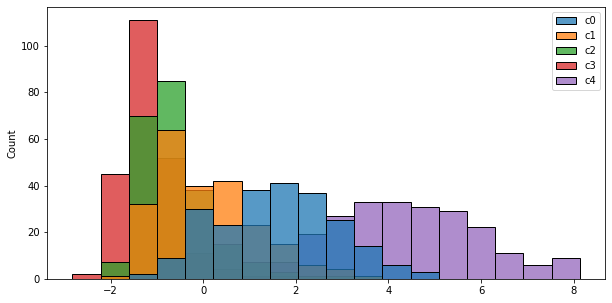

In [26]:
plt.figure(figsize=(10, 5))
sns.histplot(oof_df.iloc[idx]);
#sns.histplot(oof_df.iloc[idx][['c0', 'c4']]);

# inference

In [35]:
def get_transforms(aug=None, size=CFG.size):
    resize = A.OneOf([
        A.Resize(size, size, p=0.1),
        A.RandomCrop(size, size, p=0.9),
    ], p=1.0) if aug else A.Resize(size, size)

    return A.Compose(
        [
            resize, 
            aug,
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2()
        ],
        p=1.0,
    )

class TestDataset(Dataset):
    def __init__(self, test_df, image_paths, transform=None):
        self.test_names = test_df.image_id.values
        self.image_paths = image_paths
        self.transform = get_transforms(transform)

    def __len__(self):
        return len(self.test_names)

    def __getitem__(self, idx):
        img_name = self.test_names[idx]
        x = cv2.imread(self.image_paths + img_name)[..., ::-1]
        x = self.transform(image=x)['image']  # .to(device)
        return x, img_name

In [36]:
class Model(nn.Module):
    def __init__(self,
                 model_name='tf_efficientnet_b0_ns',
                 n_class=5,
                 pretrained=True,
                 freeze=False):
        super().__init__()
        backbone = timm.create_model(model_name,
                                       num_classes=5,
                                       in_chans=3,
                                       pretrained=pretrained)
        backbone = nn.Sequential(*backbone.children())
        
        self.backbone = backbone[:-2]
        self.global_pool = backbone[-2]
        
        n_features  = backbone[-1].in_features
        #self.drop = nn.Dropout2d(0.2)
        self.classifier = nn.Linear(n_features, n_class)
        
    def forward(self, x):
        feats = self.backbone(x)
        x = self.global_pool(feats).view(x.size(0), -1)
        #x = self.drop(x)
        x = self.classifier(x)
        return x#, feats

In [37]:
class PredictModel(nn.Module):
    def __init__(self,
                 model_name='tf_efficientnet_b0_ns',
                 model_path='./',
                 n_class=5):
        super().__init__()
        # create single
        self.model = Model(model_name, pretrained=False)
        self.freeze()
        self.model.eval().to(device)

        # load checkpoints
        checkpoints = [torch.load(path)
                       for path in glob(model_path + 'fold*.pth')]
        # create models
        self.models = [copy.deepcopy(self.model)
                       for _ in range(len(checkpoints))]
        # load weights
        for idx, checkpoint in enumerate(checkpoints):
            self.models[idx].load_state_dict(checkpoint['model_state_dict'])

    def forward(self, x):
        x = torch.mean(torch.cat([model(x)[None]
                                      for model in self.models], dim=0), dim=0)
        return x

    def freeze(self, n=None):
        for param in list(self.model.parameters())[:n]:
            param.requires_grad = False

    def unfreeze(self):
        for param in self.model.parameters():
            param.requires_grad = True

In [39]:
# debug
if 0:
    test_path = data_path
    image_path = test_path + 'train_images/'
    test_df = copy.deepcopy(train_df)

    test_ds = TestDataset(test_df=test_df, 
                          image_paths=image_path, 
                          transform=None)
    test_dl = DataLoader(test_ds, batch_size=32)

    for xs, names in progress_bar(test_dl):
        xs = xs.to(device)
        with torch.no_grad():
            preds = model(xs).detach().cpu().numpy()
        preds = np.argmax(preds, axis=1)
        test_df.loc[test_df.image_id.isin(names), 'label'] = preds
        print(preds)
    print((test_df.label.values == train_df.label.values).mean())

In [44]:
test_path = '../input/cassava-leaf-disease-classification/'
image_path = test_path + 'test_images/'
test_df = pd.read_csv(test_path + 'sample_submission.csv')

test_ds = TestDataset(test_df=test_df, 
                      image_paths=image_path, 
                      transform=None)
test_dl = DataLoader(test_ds, batch_size=32)

for xs, names in test_dl:
    xs = xs.to(device)
    preds = model(xs).detach().cpu().numpy()
    preds = np.argmax(preds, axis=1)
    test_df.loc[test_df.image_id.isin(names), 'label'] = preds
    
test_df

,image_id,label
0,2216849948.jpg,4


In [45]:
test_df.to_csv('submission.csv')